# CAS KAGGLE: PROBLEMA DE CLASSIFICACIÓ DE TEXT
En aquesta practica analitzarem un dataset que classifica les webs segons la categoria a la qual pertanyen.

A continuació mostrarem les llibreries necessaries per aquest treball i la informació de la base de dades:

In [2]:
#http://www.kaggle.com/hetulmehta/website-classification

from sklearn.datasets import make_regression
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV

from wordcloud import WordCloud, STOPWORDS
from time import time

# Carreguem el dataset:
dataset = pd.read_csv('data/website_classification.csv', header=0, delimiter=',')
data = dataset.values

dataset

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


In [4]:
pd.DataFrame(dataset.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

## 1. ANALISIS DE DADES

- Aquest dataset conté una llista de pàgines web on cadascuna està classificada segons la categoria a la que pertany.
- En concret, conté 1408 entrades/dades (files) i 4 atributs (col·lumnes).
- Els atributs: un d'ells es l'índex numéric ("Unnamed: 0") i els altres 3 son de tipus object ("website_url", "cleaned_website_text", i "Category").
- L'atribut target o objectiu es el "Category" ja que voldrem predir la categoria a la qual pertanyen les pàgines web.
- No conté valors nuls en cap atribut, per tant no haurem de tractar-los.
- Com no tenim dades numériques (tret del index) tampoc podem treure outliers ni fer normalitzacions.

### LLISTA D'ATRIBUTS:
- 0: Unnamed: 0 ->           indica l'índex de la fila (pàgina web): [0,1,2,3,4...].
- 1: website_url ->          conté la URL de cada pàgina. És única: [www.algo.org, www.mosca.es...].
- 2: cleaned_website_text -> conté la llista de les paraules clau de la pàgina, i les podrem fer servir per estudiar a quina categoria pertanyen: [official site, good, hotel, vacation...].
- 3: Category ->             té les categories de totes les pàgines web: [Adult, Travel...]. És el atribut objectiu.

In [5]:
# Eliminem l'atribut index "Unnamed: 0" ja que no ens està aportant res.
df = dataset.drop('Unnamed: 0', axis=1)
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [6]:
# Eliminem les webs repetides:
df = df.drop_duplicates(subset='website_url').reset_index(drop=True)
df.shape

(1384, 3)

In [7]:
# Creem un atribut "cat_id" que contindrà la id de la categoria. Ens serà útil per a que el model entengui les diferencies.
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

# Diccionari de categoria amb el seu id:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [8]:
category_to_id

{'Travel': 0,
 'Social Networking and Messaging': 1,
 'News': 2,
 'Streaming Services': 3,
 'Sports': 4,
 'Photography': 5,
 'Law and Government': 6,
 'Health and Fitness': 7,
 'Games': 8,
 'E-Commerce': 9,
 'Forums': 10,
 'Food': 11,
 'Education': 12,
 'Computers and Technology': 13,
 'Business/Corporate': 14,
 'Adult': 15}

In [9]:
id_to_category

{0: 'Travel',
 1: 'Social Networking and Messaging',
 2: 'News',
 3: 'Streaming Services',
 4: 'Sports',
 5: 'Photography',
 6: 'Law and Government',
 7: 'Health and Fitness',
 8: 'Games',
 9: 'E-Commerce',
 10: 'Forums',
 11: 'Food',
 12: 'Education',
 13: 'Computers and Technology',
 14: 'Business/Corporate',
 15: 'Adult'}

In [10]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
212,Sports,4
390,Photography,5
575,Law and Government,6
658,Health and Fitness,7
748,Games,8
790,E-Commerce,9


Hem eliminat el atribut 'Unnamed: 0' que no ens aporta res i hem afegit el 'category_id' per donar un id numèric a la categoria.

A continuació mostrem un gràfic de les webs que tenim per cada categoria:

<IPython.core.display.Javascript object>


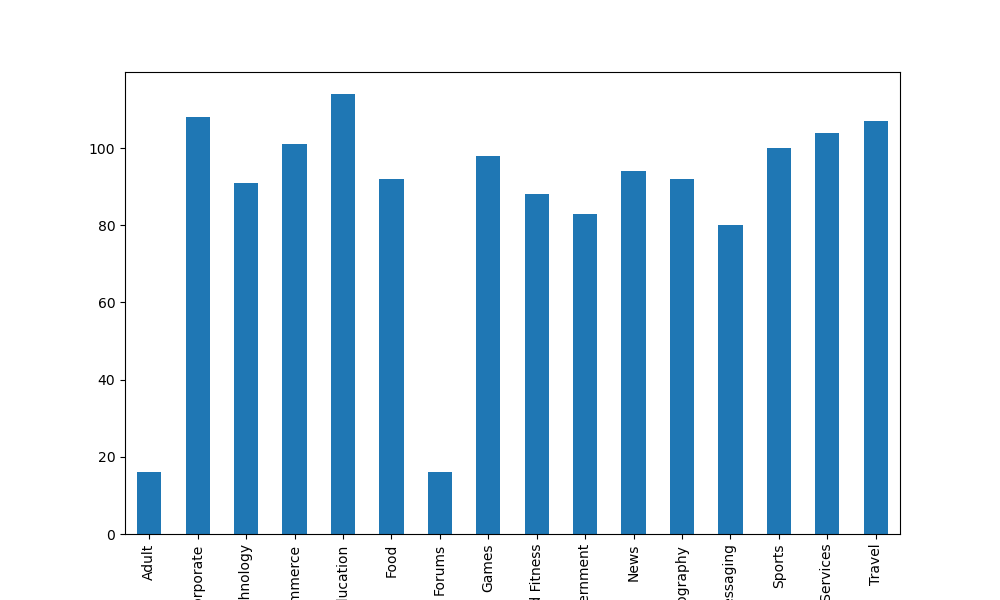

In [11]:
# Ordenem el dataset segons les categories:
df = df.sort_values(by='Category',ascending=True)

# Mostrem el numero de webs per a cada classe:
fig = plt.figure(figsize=(10,6))
df.groupby('Category').cleaned_website_text.count().plot.bar()
plt.show()

Ara veurem el WORDCLOUD de totes les categories amb les paraules que més s'han utilitzat

<IPython.core.display.Javascript object>


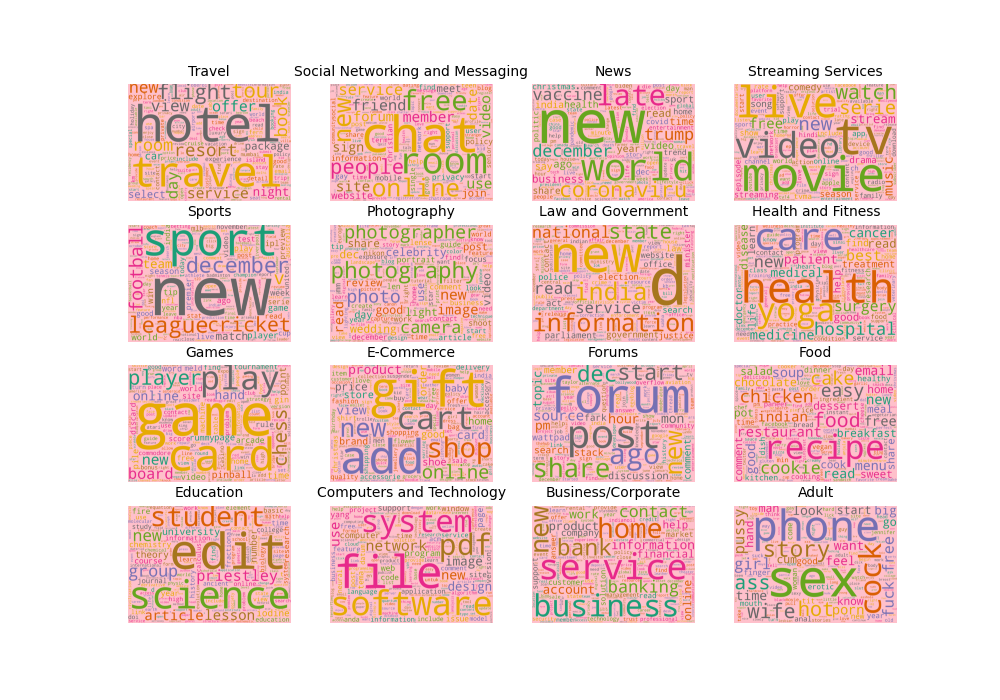

In [57]:
# WORDCLOUD: Per mostrar les paraules més utilitzades en cada categoria:

plt.figure(figsize=(10,7))
subset = df[df['Category']=='Travel']
text = subset.cleaned_website_text.values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,1)
plt.axis('off')
plt.title("Travel",fontsize=10)
plt.imshow(cloud1)
subset = df[df['Category']=='Social Networking and Messaging']
text = subset.cleaned_website_text.values
cloud2=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,2)
plt.axis('off')
plt.title("Social Networking and Messaging",fontsize=10)
plt.imshow(cloud2)
subset = df[df['Category']=='News']
text = subset.cleaned_website_text.values
cloud3=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,3)
plt.axis('off')
plt.title("News",fontsize=10)
plt.imshow(cloud3)

subset = df[df['Category']=='Streaming Services']
text = subset.cleaned_website_text.values
cloud4=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,4)
plt.axis('off')
plt.title("Streaming Services",fontsize=10)
plt.imshow(cloud4)

subset = df[df['Category']=='Sports']
text = subset.cleaned_website_text.values
cloud5=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,5)
plt.axis('off')
plt.title('Sports',fontsize=10)
plt.imshow(cloud5)

subset = df[df['Category']=='Photography']
text = subset.cleaned_website_text.values
cloud6=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,6)
plt.axis('off')
plt.title("Photography",fontsize=10)
plt.imshow(cloud6)

subset = df[df['Category']=='Law and Government']
text = subset.cleaned_website_text.values
cloud7=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,7)
plt.axis('off')
plt.title("Law and Government",fontsize=10)
plt.imshow(cloud7)

subset = df[df['Category']=='Health and Fitness']
text = subset.cleaned_website_text.values
cloud8=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,8)
plt.axis('off')
plt.title("Health and Fitness",fontsize=10)
plt.imshow(cloud8)

subset = df[df['Category']=='Games']
text = subset.cleaned_website_text.values
cloud9=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,9)
plt.axis('off')
plt.title("Games",fontsize=10)
plt.imshow(cloud9)

subset = df[df['Category']=='E-Commerce']
text = subset.cleaned_website_text.values
cloud10=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,10)
plt.axis('off')
plt.title("E-Commerce",fontsize=10)
plt.imshow(cloud10)

subset = df[df['Category']=='Forums']
text = subset.cleaned_website_text.values
cloud11=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,11)
plt.axis('off')
plt.title("Forums",fontsize=10)
plt.imshow(cloud11)

subset = df[df['Category']=='Food']
text = subset.cleaned_website_text.values
cloud12=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,12)
plt.axis('off')
plt.title("Food",fontsize=10)
plt.imshow(cloud12)

subset = df[df['Category']=='Education']
text = subset.cleaned_website_text.values
cloud13=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,13)
plt.axis('off')
plt.title("Education",fontsize=10)
plt.imshow(cloud13)

subset =df[df['Category']=='Computers and Technology']
text = subset.cleaned_website_text.values
cloud14=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,14)
plt.axis('off')
plt.title("Computers and Technology",fontsize=10)
plt.imshow(cloud14)

subset = df[df['Category']=='Business/Corporate']
text = subset.cleaned_website_text.values
cloud15=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,15)
plt.axis('off')
plt.title("Business/Corporate",fontsize=10)
plt.imshow(cloud15)

subset = df[df['Category']=='Adult']
text = subset.cleaned_website_text.values
cloud16=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,16)
plt.axis('off')
plt.title("Adult",fontsize=10)
plt.imshow(cloud16)
plt.show()

## 2. PREPROCESSING:
Les dades de les que disposem son paraules, però els nostres algoritmes y classificadors d'aprenentatge no poden processar dades de text directament, esperem millor dades numèriques.
Per a preprocessar les dades transformarem les nostres dades de text en números, tenint en compte la freqüéncia en la que surten les paraules. 
Concretament, calcularem una mesura que es diu Frequència de Termes i Frequència de dades inversa:

In [17]:
# Frequència de Termes i Frequència de dades inversa = tf-idf.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, ngram_range=(1, 2), stop_words='english', norm='l2')

# Transformem el cleaned_text a un vector
features = tfidf.fit_transform(df.cleaned_website_text).toarray()
labels = df.category_id

print("Les %d dades de text es representen per %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
features.shape

Les 1384 dades de text es representen per 14553 features (TF-IDF score of unigrams and bigrams)


(1384, 14553)

In [13]:
features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02873551, 0.03269911,
        0.02530703]])

In [14]:
labels

1383    15
1368    15
1369    15
1370    15
1371    15
        ..
76       0
77       0
79       0
67       0
0        0
Name: category_id, Length: 1384, dtype: int64

Utilitzarem la funció de sklearn.feature_selection.chi2 per trobar els termes mes correlacionats amb cadascuna de les categories

In [18]:
# Buscarem les 5 paraules més correlacionades de cadascuna de les categories:
n = 5
for Category, category_id in sorted(category_to_id.items()):
    chi2_f = chi2(features, labels == category_id) # chi2: per trobar els termes més correlacionats en cada categoria.
    #print(chi2_f)
    idx = np.argsort(chi2_f[0])
    #print(idx)
    feature_names = np.array(tfidf.get_feature_names())[idx]
    #print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] # 1 paraula
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # 2 paraules
    print("\n %s ==>" %(Category))
    print("  · Most Correlated Unigrams are: %s" %(', '.join(unigrams[-n:])))
    print("  · Most Correlated Bigrams are: %s" %(', '.join(bigrams[-n:])))


 Adult ==>
  · Most Correlated Unigrams are: fuck, cock, porn, erotic, xxx
  · Most Correlated Bigrams are: year old, porn star, anal sex, big cock, sex toys

 Business/Corporate ==>
  · Most Correlated Unigrams are: client, accountant, accounting, investment, banking
  · Most Correlated Bigrams are: audio visual, commercial real, home products, real estate, online banking

 Computers and Technology ==>
  · Most Correlated Unigrams are: compiler, acm, file, windows, software
  · Most Correlated Bigrams are: file format, open source, programming language, web hosting, source code

 E-Commerce ==>
  · Most Correlated Unigrams are: jewellery, grocery, accessory, accessories, shipping
  · Most Correlated Bigrams are: new arrival, online shopping, grocery shopping, add cart, free shipping

 Education ==>
  · Most Correlated Unigrams are: physics, science, biology, university, chemistry
  · Most Correlated Bigrams are: science education, state university, earth science, periodic table, open

## 3. SELECCIÓ DEL MODEL:
Ara ja tenim les dades llestes per experimentar amb models. Tots els models probats han estat probats i executats en 70% train, 30% test i amb el cross-validation k-fold, amb k=5.

He agafat una llista de 5 models per fer una comparativa i veure quin d'aquests dona millors resultats:
- RandomForest
- Màquina de vectors de suport Lineal
- Naive Bayes Multinomial
- Naive Bayes Gaussià
- Regressió Logística

In [46]:
X = df['cleaned_website_text'] # Paraules de text
y = df['Category'] # El target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0) # 70% train, 30% test
# Podem probar altres mesures (80%,20% o 50%,50%)

In [19]:
# models que probem per seleccionar:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB(),
    LogisticRegression(random_state=0)
]

# Cross-validation k-fold amb k=5:
k = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    start_time = time()
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=k)
    elapsed_time = time() - start_time # Temps d'execució del model amb el CV on k=5.
    print('Temps de execució del {} = {}'.format(model, elapsed_time))
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

Temps de execució del RandomForestClassifier(max_depth=5, random_state=0) = 4.688607454299927
Temps de execució del LinearSVC() = 1.7947497367858887
Temps de execució del MultinomialNB() = 0.7637832164764404
Temps de execució del GaussianNB() = 5.195427894592285
Temps de execució del LogisticRegression(random_state=0) = 14.141105651855469


,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.765343
1,RandomForestClassifier,1,0.707581
2,RandomForestClassifier,2,0.750903
3,RandomForestClassifier,3,0.736462
4,RandomForestClassifier,4,0.775362
5,LinearSVC,0,0.931408
6,LinearSVC,1,0.906137
7,LinearSVC,2,0.913357
8,LinearSVC,3,0.888087
9,LinearSVC,4,0.916667


In [20]:
# Mesurem el model amb el millor accuracy mitjà:
mac = cv_df.groupby('model_name').accuracy.mean()
mac.columns = ['Mean Accuracy']
mac

model_name
GaussianNB                0.711722
LinearSVC                 0.911131
LogisticRegression        0.885839
MultinomialNB             0.856221
RandomForestClassifier    0.747130
Name: accuracy, dtype: float64

### EVALUACIÓ DEL MODEL LINEAR-SVC

El Regressor Logístic i el LinearSVC son els models que millor funcionen i d'aquests agafarem el millor: el LinearSVC té un 90% d'accuracy i s'executa en 2,3 sec. el LogisticRegression té un 88% d'accuracy pero triga 18 segons en executar!
Llavors agafarem el 'LinearSVC' perque te un major accuracy i s'executa molt més ràpid.

Experimentarem amb la Màquina de vectors de suport Lineal (LinearSVC) i calibrarem el nostre model.

In [21]:
# Probem el classificador de LINEAR_SVC:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.3, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calibrem el model i mirem la seva accuracy:
calibrated_svc = CalibratedClassifierCV(base_estimator=model, cv="prefit")
calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print("Accuracy calibrat: %.3f" % metrics.accuracy_score(y_test, predicted))
#print(y_test.shape)
#print(predicted)

Accuracy calibrat: 0.933


A continuació mostro la matriu de confusió on podrem apreciar les dades de classificació que ha fet el nostre model:

<IPython.core.display.Javascript object>


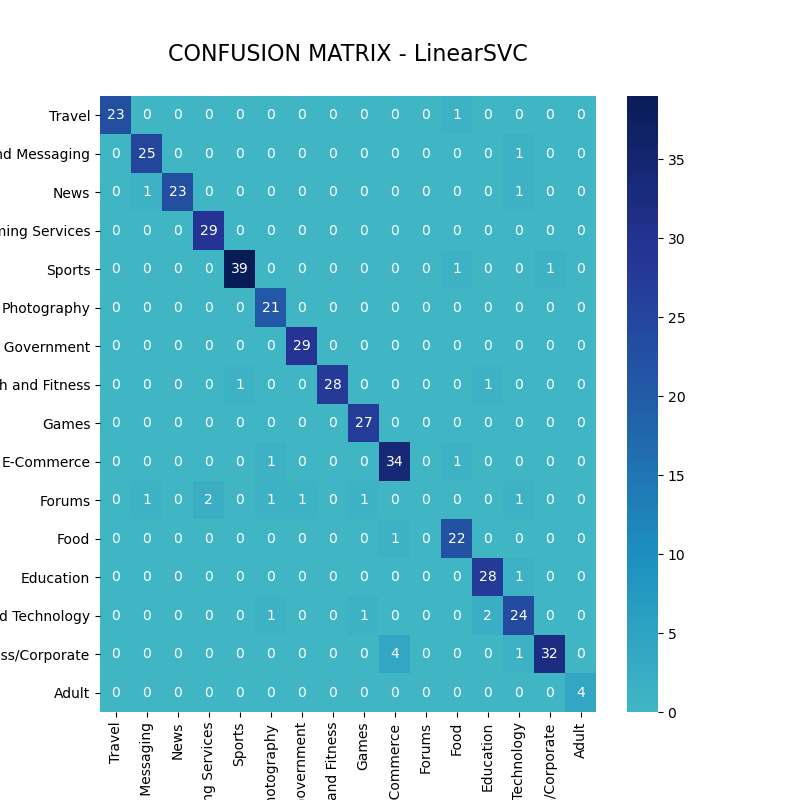

In [22]:
# Mirem la matriu de confusió:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d', center=0, cmap='YlGnBu',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)

plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [23]:
# Classification report
print('MÈTRIQUES DE CLASSIFICACIÓ:\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

MÈTRIQUES DE CLASSIFICACIÓ:

                                 precision    recall  f1-score   support

                          Adult       1.00      0.96      0.98        24
             Business/Corporate       0.93      0.96      0.94        26
       Computers and Technology       1.00      0.92      0.96        25
                     E-Commerce       0.94      1.00      0.97        29
                      Education       0.97      0.95      0.96        41
                           Food       0.88      1.00      0.93        21
                         Forums       0.97      1.00      0.98        29
                          Games       1.00      0.93      0.97        30
             Health and Fitness       0.93      1.00      0.96        27
             Law and Government       0.87      0.94      0.91        36
                           News       0.00      0.00      0.00         7
                    Photography       0.88      0.96      0.92        23
Social Networking and

C:\Users\oscar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


micro avg = mitjana pero tenint més en compte les classes de major frequencia, i menys les menors.
macro avg = mitjana de les 16 classes per igual.
weighted avg = mitjana dels pesos.

Hi han certs errors en la nostra classificació que es poden apreciar en la matriu de confusió. Tots els elements que estiguin en la diagonal vol dir que estàn ben classificats, i els que no obviament no ho estàn.
A continuació mostraré les classificacions erronies que ha fet el nostre model i amb quina classe s'han equivocat:

In [24]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] > 0: # Mostra tots els errors
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 'cleaned_website_text']])

'News' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
544,News,bloomberg robot bloomberg detect unusual activ...


'Forums' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
854,Forums,alternate history discussion forum search disc...


'Forums' predicted as 'Streaming Services' : 2 examples.


,Category,cleaned_website_text
861,Forums,wattpad story live wattpad connect global comm...
850,Forums,india forums latest entertainment news india f...


'Health and Fitness' predicted as 'Sports' : 1 examples.


,Category,cleaned_website_text
675,Health and Fitness,ellen broken jaw tips tips people suffer broke...


'E-Commerce' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Forums' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text
853,Forums,aviation forums skip content search search qui...


'Computers and Technology' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text
1228,Computers and Technology,flipcode archives welcome flipcode archives fi...


'Forums' predicted as 'Law and Government' : 1 examples.


,Category,cleaned_website_text
862,Forums,india skyscrapercity namaste city ahmedabad be...


'Forums' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
852,Forums,aelyria forward forums welcome aelyria page au...


'Computers and Technology' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
1214,Computers and Technology,retrosoftware main page retro software homebre...


'Food' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
863,Food,deliciously ella live well useful vegetable co...


'Business/Corporate' predicted as 'E-Commerce' : 4 examples.


,Category,cleaned_website_text
1361,Business/Corporate,buy brand gps electronics accessories cheap gp...
1360,Business/Corporate,laptop computers desktops printers ink toner h...
1367,Business/Corporate,thrive market healthy living easy buy healthy ...
1308,Business/Corporate,sale combs wrecker sale hurry sell opportunity...


'Travel' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
99,Travel,toggle navigation menu lang lang cultureui hom...


'Sports' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
294,Sports,diario gol real madrid messi diariogol james r...


'E-Commerce' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
872,E-Commerce,pioneer woman recipes country life style enter...


'Health and Fitness' predicted as 'Education' : 1 examples.


,Category,cleaned_website_text
668,Health and Fitness,page find learn ayurveda cart oops page find t...


'Computers and Technology' predicted as 'Education' : 2 examples.


,Category,cleaned_website_text
1175,Computers and Technology,quantum algorithms quantum computing blog quan...
1231,Computers and Technology,lambda ultimate programming languages weblog l...


'Social Networking and Messaging' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
323,Social Networking and Messaging,good dating site singles meeting russian girl ...


'News' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
565,News,index index modified size description


'Forums' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
855,Forums,ars technica openforum index page hardware twe...


'Education' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
1014,Education,calculator home page calculator software onlin...


'Business/Corporate' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
1341,Business/Corporate,freelancer freelance jobs freelance projects f...


'Sports' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
256,Sports,sport job sport news sport feature sports mana...


Evaluarem de nou el test per trobar els termes més relacionats amb les categories que ha escollit el nostre model d'entrenament

In [67]:
# Tornem a evaluar el test per trobar els termes més relacionats amb les categories:
model.fit(features, labels)

N = 5
for Category, category_id in sorted(category_to_id.items()):
    # Eliminem el chi2 perque volem les dades del nostre model:
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n '{}' ==>".format(Category))
    print("  · Top unigrams: %s" %(', '.join(unigrams)))
    print("  · Top bigrams: %s" %(', '.join(bigrams)))


 'Adult' ==>
  · Top unigrams: sex, bdsm, cock, fuck, erotic
  · Top bigrams: year old, day ago, sex toys, dec nov, big cock

 'Business/Corporate' ==>
  · Top unigrams: bank, business, aircraft, services, freelance
  · Top bigrams: real estate, audio visual, view site, home products, site work

 'Computers and Technology' ==>
  · Top unigrams: software, file, pdf, programming, computer
  · Top bigrams: come soon, machine learning, web hosting, source code, website design

 'E-Commerce' ==>
  · Top unigrams: gift, shipping, grocery, fashion, item
  · Top bigrams: add cart, free shipping, gift card, grocery shopping, greeting card

 'Education' ==>
  · Top unigrams: science, student, university, chemistry, exam
  · Top bigrams: open access, case study, earth science, real world, learn learn

 'Food' ==>
  · Top unigrams: recipe, restaurant, cake, bakery, meals
  · Top bigrams: order online, pm pm, plant base, instant pot, breakfast lunch

 'Forums' ==>
  · Top unigrams: forum, forums, 

Podem veure que les paraules tenen sentit dins de la categoria a la que pertanyen, per tant hem fet una bona feina.